<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/Anomaly2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet101
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import random
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input,Flatten,Reshape,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.regularizers import l1
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error

In [3]:
# 정상 데이터
train_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/train/good/*')
# 이상 데이터들
test_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/broken_large/*')
test_dir_broken_small = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/broken_small/*')
test_dir_contamination = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/contamination/*')

# 정상 테스트 데이터
test_dir_good = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/good/*')

In [4]:
train_images = []
test_images = []
target_size = (224, 224)

In [5]:
for img_path in train_dir:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    train_images.append(normalized_img_array)

for img_path in test_dir + test_dir_broken_small + test_dir_contamination:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)  # 수정: img_array 대신 resized_img를 사용
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    test_images.append(normalized_img_array)

In [6]:
# 데이터 준비
train_images = np.array(train_images)
test_images = np.array(test_images)

In [7]:
# 랜덤 시드 설정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
X_train,X_test = train_test_split(train_images, test_size=0.2, random_state=42)
X_train.shape

(167, 224, 224, 3)

In [9]:
# 인코더 모델 정의
input_layer = Input(shape=(224, 224, 3))  # 이미지의 크기와 채널 수 (224x224x3)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 디코더 모델 정의
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

In [10]:
nb_epoch = 20
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/20
6/6 [==============================] - 25s 3s/step - loss: 0.1581 - accuracy: 0.4442 - val_loss: 0.1470 - val_accuracy: 0.4482
Epoch 2/20
6/6 [==============================] - 21s 4s/step - loss: 0.1390 - accuracy: 0.4462 - val_loss: 0.1238 - val_accuracy: 0.4446
Epoch 3/20
6/6 [==============================] - 18s 3s/step - loss: 0.1185 - accuracy: 0.4459 - val_loss: 0.1090 - val_accuracy: 0.4054
Epoch 4/20
6/6 [==============================] - 21s 3s/step - loss: 0.0993 - accuracy: 0.1718 - val_loss: 0.0864 - val_accuracy: 0.0730
Epoch 5/20
6/6 [==============================] - 19s 3s/step - loss: 0.0746 - accuracy: 0.0859 - val_loss: 0.0568 - val_accuracy: 0.1098
Epoch 6/20
6/6 [==============================] - 19s 3s/step - loss: 0.0478 - accuracy: 0.1449 - val_loss: 0.0323 - val_accuracy: 0.1728
Epoch 7/20
6/6 [==============================] - 18s 3s/step - loss: 0.0261 - accuracy: 0.1841 - val_loss: 0.0178 - val_accuracy: 0.1915
Epoch 8/20
6/6 [==================

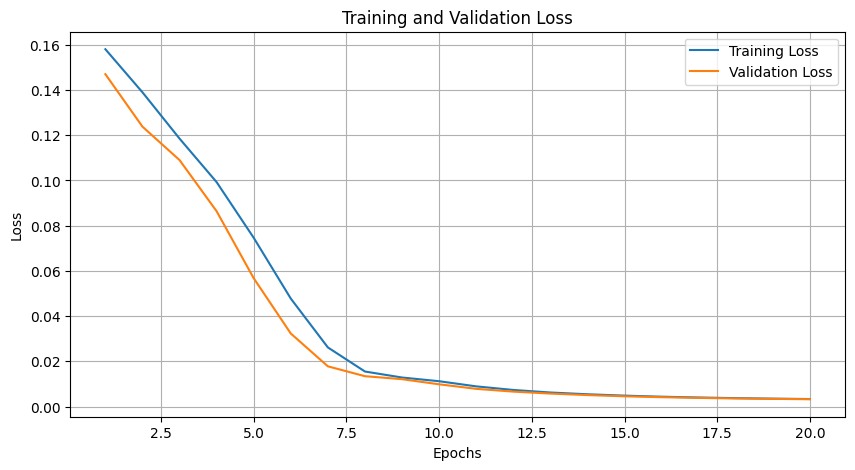

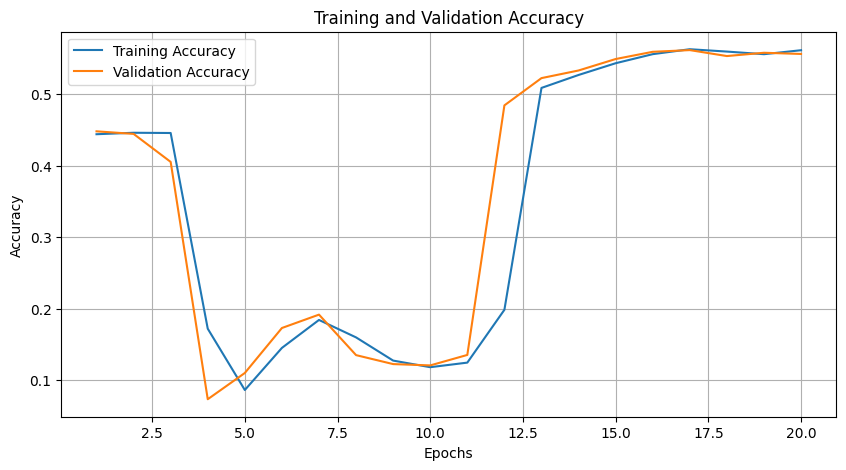

In [11]:
# 학습 결과를 기록한 history 객체에서 Loss와 Accuracy 추출
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Epoch 수
epochs = range(1, len(loss) + 1)

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

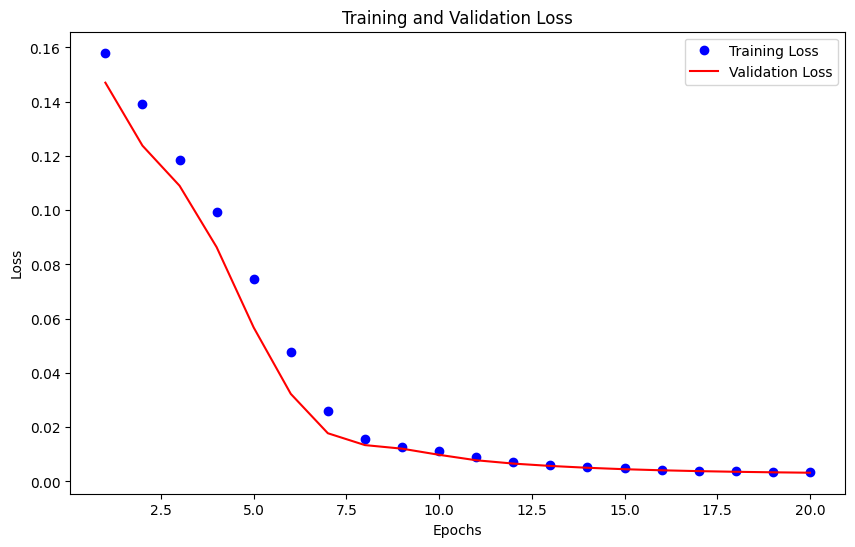

In [12]:
# 손실 함수 값 추출
loss = history['loss']
val_loss = history['val_loss']

# 그래프 그리기
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
def compare_images(image1, image2):
    # 이미지를 그레이스케일로 변환
    gray_image1 = np.mean(image1, axis=2)
    gray_image2 = np.mean(image2, axis=2)

    # 이미지 비교
    (score, _) = ssim(gray_image1, gray_image2, full=True)
    return score

# 두 개의 이미지 비교
def classify_images(image1, image2):
    similarity_score = compare_images(image1, image2)
    return similarity_score

2/2 [==============================] - 1s 228ms/step


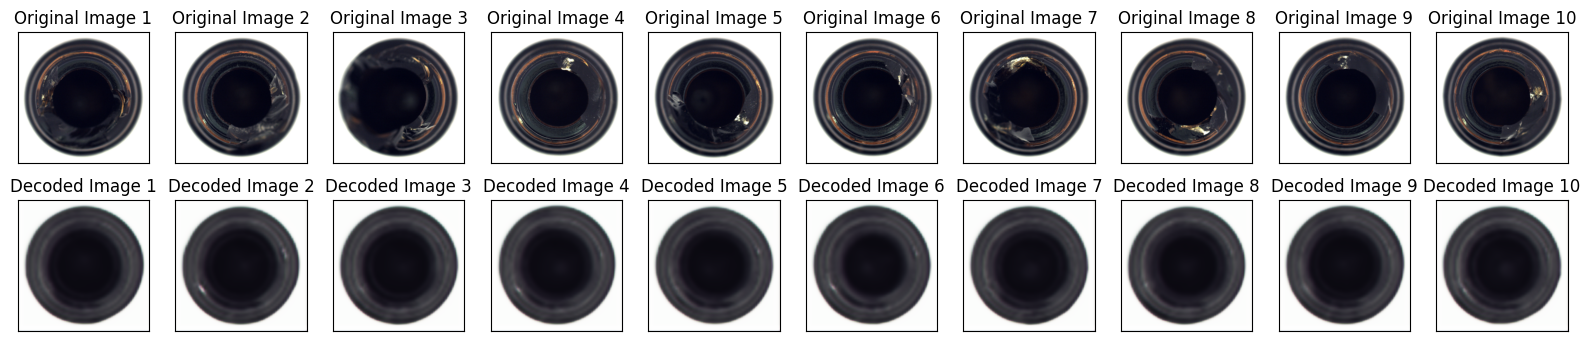

In [45]:
# test_images 모델에 입력하여 재구성 이미지 생성
decoded_train_imgs = autoencoder.predict(X_train)
# test_images 모델에 입력하여 재구성 이미지 생성
decoded_test_imgs = autoencoder.predict(X_test)
n = 10
# 이미지 개수 설
# 원본 이미지와 재구성 이미지 비교 그래프
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(224, 224, 3))
    plt.title(f'Original Image {i+1}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test_imgs[i].reshape(224, 224, 3))
    plt.title(f'Decoded Image {i+1}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [39]:
# 이미지 간의 일치율 비교 및 출력
for i in range(n):
    image1 = test_images[i]
    image2 = decoded_test_imgs[i]
    similarity_score = classify_images(image1, image2)
    print(f"Test Image {i+1}와 Decoded Image의 일치율: {similarity_score:.4f}")

Test Image 1와 Decoded Image의 일치율: 0.7623
Test Image 2와 Decoded Image의 일치율: 0.7864
Test Image 3와 Decoded Image의 일치율: 0.7885
Test Image 4와 Decoded Image의 일치율: 0.7536
Test Image 5와 Decoded Image의 일치율: 0.7734
Test Image 6와 Decoded Image의 일치율: 0.7674
Test Image 7와 Decoded Image의 일치율: 0.7750
Test Image 8와 Decoded Image의 일치율: 0.7819
Test Image 9와 Decoded Image의 일치율: 0.7939
Test Image 10와 Decoded Image의 일치율: 0.7702


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

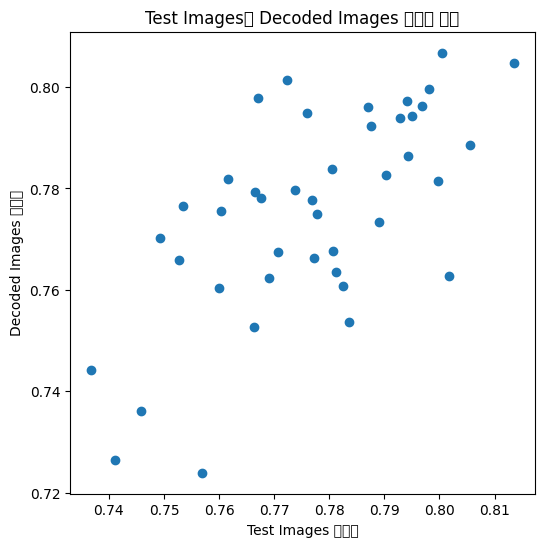

In [46]:
n2 = min(50, len(test_images), len(decoded_train_imgs), len(decoded_test_imgs))  # 시각화할 이미지 개수 (최대 10개)

# 이미지 간의 일치율 계산
similarity_scores = [classify_images(test_images[i], decoded_train_imgs[i]) for i in range(n2)]
similarity_scores_test = [classify_images(test_images[i], decoded_test_imgs[i]) for i in range(n2)]

# 산점도 그리기
plt.figure(figsize=(6, 6))
plt.scatter(similarity_scores, similarity_scores_test)
plt.xlabel('Test Images 일치율')
plt.ylabel('Decoded Images 일치율')
plt.title('Test Images와 Decoded Images 일치율 비교')
plt.show()